In [21]:
import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
import torch.optim as optim
import argparse
import numpy as np
import time
from copy import deepcopy
import seaborn as sns
import matplotlib.pyplot as plt

In [22]:
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)
trainset, valset = torch.utils.data.random_split(trainset, [40000, 10000])
testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)
partition = {'train': trainset, 'val':valset, 'test':testset}

Files already downloaded and verified
Files already downloaded and verified


In [23]:
class MLP(nn.Module):
    def __init__(self, in_dim, out_dim, hid_dim, n_layer, act, dropout, use_bn, w_initial):
        super(MLP, self).__init__()
        self.in_dim = in_dim
        self.out_dim = out_dim
        self.hid_dim = hid_dim
        self.n_layer = n_layer
        self.act = act
        self.dropout = dropout
        self.use_bn = use_bn
        self.w_initial = w_initial

        # ====== Create Linear Layers ====== #
        self.fc1 = nn.Linear(self.in_dim, self.hid_dim)

        self.linears = nn.ModuleList()
        self.bns = nn.ModuleList()
        for i in range(self.n_layer-1):
            self.linears.append(nn.Linear(self.hid_dim, self.hid_dim))
            if self.use_bn:
                self.bns.append(nn.BatchNorm1d(self.hid_dim))

        self.fc2 = nn.Linear(self.hid_dim, self.out_dim)

        # ====== Create Activation Function ====== #
        if self.act == 'relu':
            self.act = nn.ReLU()
        elif self.act == 'leakyrelu':
            self.act = nn.LeakyReLU()
        elif self.act == 'sigmoid':
            self.act = nn.Sigmoid()
        elif self.act == 'tanh':
            self.act = nn.Tanh()
        else:
            raise ValueError('no valid activation function selected!')

        # ====== Create Regularization Layer ======= #
        self.dropout = nn.Dropout(self.dropout)

        if self.w_initial == 'xavier':
            self.xavier_init()
        elif self.w_initial == 'he':
            self.he_init()
        else:
            raise ValueError("no valid initialization method selected!")

    def forward(self, x):
        x = self.act(self.fc1(x))
        for i in range(len(self.linears)):
            x = self.act(self.linears[i](x))
            if self.use_bn:
                x = self.bns[i](x)
            x = self.dropout(x)
        x = self.fc2(x)
        return x

    def xavier_init(self):
        for linear in self.linears:
            nn.init.xavier_normal_(linear.weight)
            linear.bias.data.fill_(0.01)

    def he_init(self):
        for linear in self.linears:
            nn.init.kaiming_normal_(linear.weight, nonlinearity='leaky_relu') # nonlinearity='leaky_relu' (default)
            linear.bias.data.fill_(0.01)

In [24]:
device = 'cuda:0'
def train(net, partition, optimizer, criterion, args):
    trainloader = torch.utils.data.DataLoader(partition['train'],
                                              batch_size=args.train_batch_size,
                                              shuffle=True, num_workers=2)
    net.train()

    correct = 0
    total = 0
    train_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        optimizer.zero_grad()
        # get the inputs
        inputs, labels = data
        inputs = inputs.view(-1, 3072)
        inputs = inputs.to(device)
        labels = labels.to(device)
        outputs = net(inputs)

        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        train_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    train_loss = train_loss / len(trainloader)
    train_acc = 100 * correct / total
    return net, train_loss, train_acc

In [25]:
def validate(net, partition, criterion, args):
    valloader = torch.utils.data.DataLoader(partition['val'],
                                            batch_size=args.test_batch_size,
                                            shuffle=False, num_workers=2)
    net.eval()

    correct = 0
    total = 0
    val_loss = 0
    with torch.no_grad():
        for data in valloader:
            images, labels = data
            images = images.view(-1, 3072)
            images = images.to(device)
            labels = labels.to(device)
            outputs = net(images)

            loss = criterion(outputs, labels)

            val_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

        val_loss = val_loss / len(valloader)
        val_acc = 100 * correct / total
    return val_loss, val_acc

In [26]:
def test(net, partition, args):
    testloader = torch.utils.data.DataLoader(partition['test'],
                                             batch_size=args.test_batch_size,
                                             shuffle=False, num_workers=2)
    net.eval()

    correct = 0
    total = 0
    with torch.no_grad():
        for data in testloader:
            images, labels = data
            images = images.view(-1, 3072)
            images = images.to(device)
            labels = labels.to(device)

            outputs = net(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

        test_acc = 100 * correct / total
    return test_acc

In [27]:
import hashlib
import json
from os import listdir
from os.path import isfile, join
import pandas as pd

def save_exp_result(setting, result):
    exp_name = setting['exp_name']
    #del setting['epoch']
    #del setting['test_batch_size']

    hash_key = hashlib.sha1(str(setting).encode()).hexdigest()[:6]
    filename = './results/{}-{}.json'.format(exp_name, hash_key)
    result.update(setting)
    with open(filename, 'w') as f:
        json.dump(result, f)


def load_exp_result(exp_name):
    dir_path = './results'
    filenames = [f for f in listdir(dir_path) if isfile(join(dir_path, f)) if '.json' in f]
    list_result = []
    for filename in filenames:
        if exp_name in filename:
            with open(join(dir_path, filename), 'r') as infile:
                results = json.load(infile)
                list_result.append(results)
    df = pd.DataFrame(list_result) # .drop(columns=[])
    return df

In [28]:
def plot_acc(var1, var2, df):

    fig, ax = plt.subplots(1, 3)
    fig.set_size_inches(15, 6)
    sns.set_style("darkgrid", {"axes.facecolor": ".9"})

    sns.barplot(x=var1, y='train_acc', hue=var2, data=df, ax=ax[0])
    sns.barplot(x=var1, y='val_acc', hue=var2, data=df, ax=ax[1])
    sns.barplot(x=var1, y='test_acc', hue=var2, data=df, ax=ax[2])

    ax[0].set_title('Train Accuracy')
    ax[1].set_title('Validation Accuracy')
    ax[2].set_title('Test Accuracy')


def plot_loss_variation(var1, var2, df, **kwargs):

    list_v1 = df[var1].unique()
    list_v2 = df[var2].unique()
    list_data = []

    for value1 in list_v1:
        for value2 in list_v2:
            row = df.loc[df[var1]==value1]
            row = row.loc[df[var2]==value2]

            train_losses = list(row.train_losses)[0]
            val_losses = list(row.val_losses)[0]

            for epoch, train_loss in enumerate(train_losses):
                list_data.append({'type':'train', 'loss':train_loss, 'epoch':epoch, var1:value1, var2:value2})
            for epoch, val_loss in enumerate(val_losses):
                list_data.append({'type':'val', 'loss':val_loss, 'epoch':epoch, var1:value1, var2:value2})

    df = pd.DataFrame(list_data)
    g = sns.FacetGrid(df, row=var2, col=var1, hue='type', **kwargs)
    g = g.map(plt.plot, 'epoch', 'loss', marker='.')
    g.add_legend()
    g.fig.suptitle('Train loss vs Val loss')
    plt.subplots_adjust(top=0.83) # Adjusting the value of top if the title and figure overlap each other


def plot_acc_variation(var1, var2, df, **kwargs):
    list_v1 = df[var1].unique()
    list_v2 = df[var2].unique()
    list_data = []

    for value1 in list_v1:
        for value2 in list_v2:
            row = df.loc[df[var1]==value1]
            row = row.loc[df[var2]==value2]

            train_accs = list(row.train_accs)[0]
            val_accs = list(row.val_accs)[0]
            test_acc = list(row.test_acc)[0]

            for epoch, train_acc in enumerate(train_accs):
                list_data.append({'type':'train', 'Acc':train_acc, 'test_acc':test_acc, 'epoch':epoch, var1:value1, var2:value2})
            for epoch, val_acc in enumerate(val_accs):
                list_data.append({'type':'val', 'Acc':val_acc, 'test_acc':test_acc, 'epoch':epoch, var1:value1, var2:value2})

    df = pd.DataFrame(list_data)
    g = sns.FacetGrid(df, row=var2, col=var1, hue='type', **kwargs)
    g = g.map(plt.plot, 'epoch', 'Acc', marker='.')

    def show_acc(x, y, metric, **kwargs):
        plt.scatter(x, y, alpha=0.3, s=1)
        metric = "Test Acc: {:1.3f}".format(list(metric.values)[0])
        plt.text(0.05, 0.95, metric,  horizontalalignment='left', verticalalignment='center', transform=plt.gca().transAxes, bbox=dict(facecolor='yellow', alpha=0.5, boxstyle="round,pad=0.1"))
    g = g.map(show_acc, 'epoch', 'Acc', 'test_acc')

    g.add_legend()
    g.fig.suptitle('Train Accuracy vs Val Accuracy')
    plt.subplots_adjust(top=0.89)

In [29]:
import numpy as np
    
def pso(func, lb, ub, ieqcons=[], f_ieqcons=None, args=(), kwargs={}, 
        swarmsize=100, omega=0.5, phip=0.5, phig=0.5, maxiter=100, 
        minstep=1e-8, minfunc=1e-8, debug=False):
    """
    Perform a particle swarm optimization (PSO)
   
    Parameters
    ==========
    func : function
        The function to be minimized
    lb : array
        The lower bounds of the design variable(s)
    ub : array
        The upper bounds of the design variable(s)
   
    Optional
    ========
    ieqcons : list
        A list of functions of length n such that ieqcons[j](x,*args) >= 0.0 in 
        a successfully optimized problem (Default: [])
    f_ieqcons : function
        Returns a 1-D array in which each element must be greater or equal 
        to 0.0 in a successfully optimized problem. If f_ieqcons is specified, 
        ieqcons is ignored (Default: None)
    args : tuple
        Additional arguments passed to objective and constraint functions
        (Default: empty tuple)
    kwargs : dict
        Additional keyword arguments passed to objective and constraint 
        functions (Default: empty dict)
    swarmsize : int
        The number of particles in the swarm (Default: 100)
    omega : scalar
        Particle velocity scaling factor (Default: 0.5)
    phip : scalar
        Scaling factor to search away from the particle's best known position
        (Default: 0.5)
    phig : scalar
        Scaling factor to search away from the swarm's best known position
        (Default: 0.5)
    maxiter : int
        The maximum number of iterations for the swarm to search (Default: 100)
    minstep : scalar
        The minimum stepsize of swarm's best position before the search
        terminates (Default: 1e-8)
    minfunc : scalar
        The minimum change of swarm's best objective value before the search
        terminates (Default: 1e-8)
    debug : boolean
        If True, progress statements will be displayed every iteration
        (Default: False)
   
    Returns
    =======
    g : array
        The swarm's best known position (optimal design)
    f : scalar
        The objective value at ``g``
   
    """
   
    assert len(lb)==len(ub), 'Lower- and upper-bounds must be the same length'
    assert hasattr(func, '__call__'), 'Invalid function handle'
    lb = np.array(lb)
    ub = np.array(ub)
    assert np.all(ub>lb), 'All upper-bound values must be greater than lower-bound values'
   
    vhigh = np.abs(ub - lb)
    vlow = -vhigh
    
    # Check for constraint function(s) #########################################
    obj = lambda x: func(x, *args, **kwargs)
    if f_ieqcons is None:
        if not len(ieqcons):
            if debug:
                print('No constraints given.')
            cons = lambda x: np.array([0])
        else:
            if debug:
                print('Converting ieqcons to a single constraint function')
            cons = lambda x: np.array([y(x, *args, **kwargs) for y in ieqcons])
    else:
        if debug:
            print('Single constraint function given in f_ieqcons')
        cons = lambda x: np.array(f_ieqcons(x, *args, **kwargs))
        
    def is_feasible(x):
        check = np.all(cons(x)>=0)
        return check
        
    # Initialize the particle swarm ############################################
    S = swarmsize
    D = len(lb)  # the number of dimensions each particle has
    x = np.random.rand(S, D)  # particle positions
    v = np.zeros_like(x)  # particle velocities
    p = np.zeros_like(x)  # best particle positions
    fp = np.zeros(S)  # best particle function values
    g = []  # best swarm position
    fg = 1e100  # artificial best swarm position starting value
    
    for i in range(S):
        # Initialize the particle's position
        x[i, :] = lb + x[i, :]*(ub - lb)
   
        # Initialize the particle's best known position
        p[i, :] = x[i, :]
       
        # Calculate the objective's value at the current particle's
        fp[i] = obj(p[i, :])
       
        # At the start, there may not be any feasible starting point, so just
        # give it a temporary "best" point since it's likely to change
        if i==0:
            g = p[0, :].copy()

        # If the current particle's position is better than the swarm's,
        # update the best swarm position
        if fp[i]<fg and is_feasible(p[i, :]):
            fg = fp[i]
            g = p[i, :].copy()
       
        # Initialize the particle's velocity
        v[i, :] = vlow + np.random.rand(D)*(vhigh - vlow)
       
    # Iterate until termination criterion met ##################################
    it = 1
    while it<=maxiter:
        rp = np.random.uniform(size=(S, D))
        rg = np.random.uniform(size=(S, D))
        for i in range(S):

            # Update the particle's velocity
            v[i, :] = omega*v[i, :] + phip*rp[i, :]*(p[i, :] - x[i, :]) + \
                      phig*rg[i, :]*(g - x[i, :])
                      
            # Update the particle's position, correcting lower and upper bound 
            # violations, then update the objective function value
            x[i, :] = x[i, :] + v[i, :]
            mark1 = x[i, :]<lb
            mark2 = x[i, :]>ub
            x[i, mark1] = lb[mark1]
            x[i, mark2] = ub[mark2]
            fx = obj(x[i, :])
            
            # Compare particle's best position (if constraints are satisfied)
            if fx<fp[i] and is_feasible(x[i, :]):
                p[i, :] = x[i, :].copy()
                fp[i] = fx

                # Compare swarm's best position to current particle's position
                # (Can only get here if constraints are satisfied)
                if fx<fg:
                    if debug:
                        print('New best for swarm at iteration {:}: {:} {:}'.format(it, x[i, :], fx))

                    tmp = x[i, :].copy()
                    stepsize = np.sqrt(np.sum((g-tmp)**2))
                    if np.abs(fg - fx)<=minfunc:
                        print('Stopping search: Swarm best objective change less than {:}'.format(minfunc))
                        return tmp, fx
                    elif stepsize<=minstep:
                        print('Stopping search: Swarm best position change less than {:}'.format(minstep))
                        return tmp, fx
                    else:
                        g = tmp.copy()
                        fg = fx

        if debug:
            print('Best after iteration {:}: {:} {:}'.format(it, g, fg))
        it += 1

    print('Stopping search: maximum iterations reached --> {:}'.format(maxiter))
    
    if not is_feasible(g):
        print("However, the optimization couldn't find a feasible design. Sorry")
    return g, fg



In [ ]:
import matplotlib.pyplot as plt

param_log = []
train_log = []
val_log = []
test_log = []

def experiment(params):
    hid_dim = int(params[0])
    n_layer = int(params[1])
    act = int(params[2])
    dropout = params[3]
    use_bn = int(params[4])
    w_initial = int(params[5])
    opt = int(params[6])
    lr = params[7]
    l2 = params[8]

    optim_dict = {0: 'SGD', 1: 'RMSprop', 2: 'ADAM'}
    act_dict = {0: 'relu', 1: 'leakyrelu', 2: 'tanh', 3: 'sigmoid'}
    w_initial_dict = {0: 'xavier', 1: 'he'}

    net = MLP(
        in_dim=32 * 32 * 3,
        out_dim=10,
        hid_dim=hid_dim,
        n_layer=n_layer,
        act=act_dict[act],
        dropout=dropout,
        use_bn=bool(use_bn),
        w_initial=w_initial_dict[w_initial]
    )
    net = net.to(device)
    
    criterion = nn.CrossEntropyLoss()
    
    if optim_dict[opt] == 'SGD':
        optimizer = optim.SGD(net.parameters(), lr=lr, weight_decay=l2)
    elif optim_dict[opt] == 'RMSprop':
        optimizer = optim.RMSprop(net.parameters(), lr=lr, weight_decay=l2)
    elif optim_dict[opt] == 'ADAM':
        optimizer = optim.Adam(net.parameters(), lr=lr, weight_decay=l2)
    else:
        raise ValueError('In-valid optimizer choice')
    
    print(f"hid_dim: {hid_dim}, n_layer: {n_layer}, activation: {act_dict[act]}, dropout: {dropout}, use_bn: {use_bn}, w_initial: {w_initial_dict[w_initial]}, optimizer: {optim_dict[opt]}, learning_rate: {lr}, weight_decay: {l2}")

    parser = argparse.ArgumentParser()
    args = parser.parse_args("")
    
    args.train_batch_size = 256
    args.test_batch_size = 1024

    train_losses = []
    val_losses = []
    train_accs = []
    val_accs = []

    for epoch in range(20):
        ts = time.time()
        net, train_loss, train_acc = train(net, partition, optimizer, criterion, args)
        val_loss, val_acc = validate(net, partition, criterion, args)
        te = time.time()

        train_losses.append(train_loss)
        val_losses.append(val_loss)
        train_accs.append(train_acc)
        val_accs.append(val_acc)

        print('Epoch {}, Acc(train/val): {:2.2f}/{:2.2f}, Loss(train/val) {:2.2f}/{:2.2f}. Took {:2.2f} sec'.format(epoch, train_acc, val_acc, train_loss, val_loss, te-ts))

    test_acc = test(net, partition, args)

    result = {}
    result['train_losses'] = train_losses
    result['val_losses'] = val_losses
    result['train_accs'] = train_accs
    result['val_accs'] = val_accs
    result['train_acc'] = train_acc
    result['val_acc'] = val_acc
    result['test_acc'] = test_acc
    
    param_log.append((hid_dim, n_layer, act_dict[act], dropout, use_bn, w_initial_dict[w_initial], optim_dict[opt], lr, l2))
    train_log.append(train_acc)
    val_log.append(val_acc)
    test_log.append(test_acc)

    save_exp_result({"exp_name": "v2", "val_loss":val_loss, "hid_dim": hid_dim, "n_layer": n_layer, "activation": act_dict[act], "dropout": dropout, "use_bn": use_bn, "w_initial": w_initial_dict[w_initial], "optimizer": optim_dict[opt], "learning_rate": lr, "weight_decay": l2}, result)

    return val_loss

lb = [50, 1, 0, 0.1, 0, 0, 0, 0.0001, 0.0001]
ub = [500, 6, 3, 0.5, 1, 1, 2, 0.01, 0.01]  

best_params, best_score = pso(experiment, lb, ub, swarmsize=10, maxiter=10)

hid_dim: 148, n_layer: 4, activation: relu, dropout: 0.28145010077604465, use_bn: 0, w_initial: xavier, optimizer: RMSprop, learning_rate: 0.0008593333037664556, weight_decay: 0.009895852317316645
Epoch 0, Acc(train/val): 29.80/34.34, Loss(train/val) 1.94/1.82. Took 13.09 sec
Epoch 1, Acc(train/val): 35.36/35.09, Loss(train/val) 1.80/1.80. Took 12.85 sec
Epoch 2, Acc(train/val): 37.37/36.86, Loss(train/val) 1.74/1.73. Took 12.74 sec
Epoch 3, Acc(train/val): 38.29/33.89, Loss(train/val) 1.72/1.80. Took 12.02 sec
Epoch 4, Acc(train/val): 38.81/34.39, Loss(train/val) 1.70/1.78. Took 11.93 sec
Epoch 5, Acc(train/val): 39.79/39.87, Loss(train/val) 1.68/1.67. Took 11.98 sec
Epoch 6, Acc(train/val): 40.50/31.95, Loss(train/val) 1.66/1.99. Took 12.29 sec
Epoch 7, Acc(train/val): 41.28/39.94, Loss(train/val) 1.65/1.67. Took 12.20 sec
Epoch 8, Acc(train/val): 41.61/40.82, Loss(train/val) 1.63/1.66. Took 12.62 sec
Epoch 9, Acc(train/val): 41.96/40.55, Loss(train/val) 1.63/1.64. Took 13.10 sec
Epo

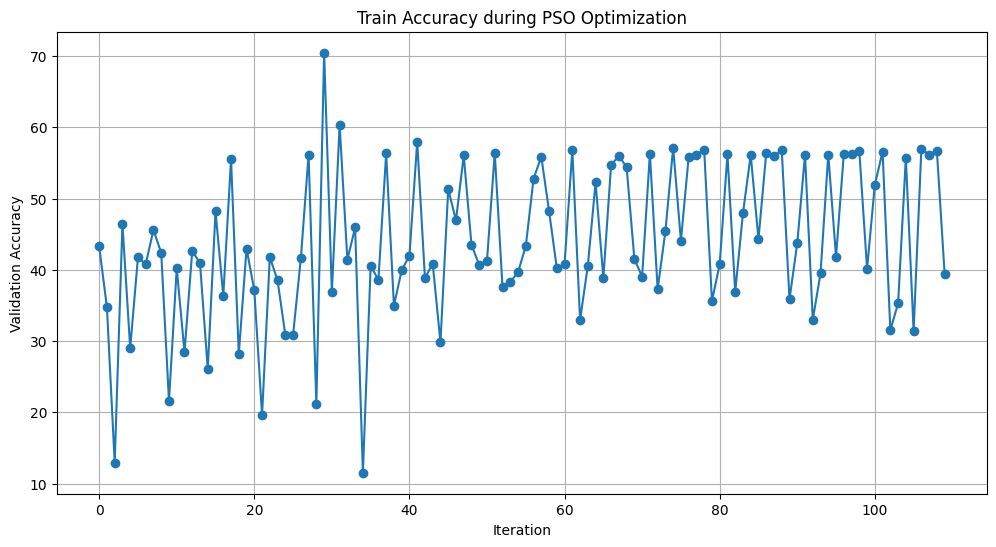

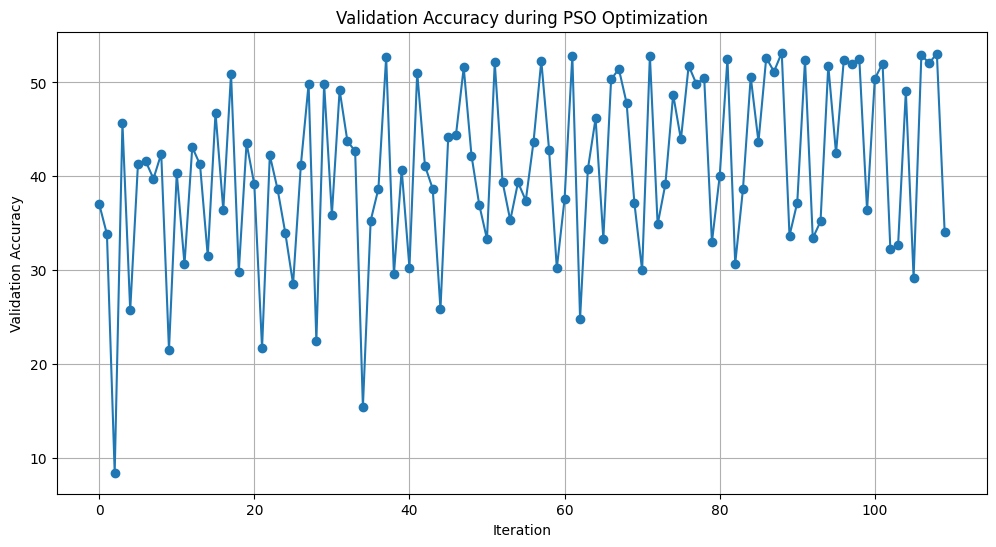

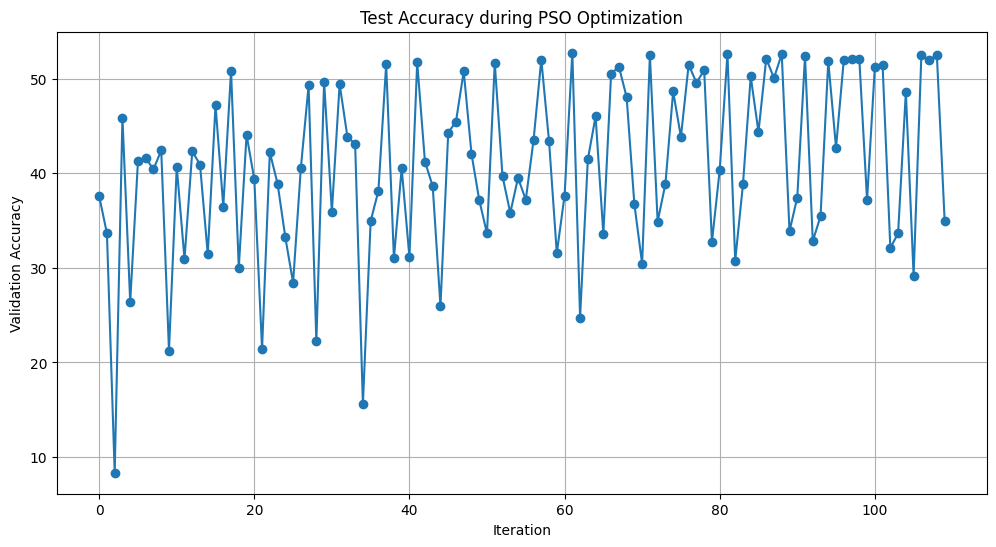

In [ ]:
plt.figure(figsize=(12, 6))
plt.plot(train_log, marker='o')
plt.title('Train Accuracy during PSO Optimization')
plt.xlabel('Iteration')
plt.ylabel('Validation Accuracy')
plt.grid(True)
plt.show()

plt.figure(figsize=(12, 6))
plt.plot(val_log, marker='o')
plt.title('Validation Accuracy during PSO Optimization')
plt.xlabel('Iteration')
plt.ylabel('Validation Accuracy')
plt.grid(True)
plt.show()

plt.figure(figsize=(12, 6))
plt.plot(test_log, marker='o')
plt.title('Test Accuracy during PSO Optimization')
plt.xlabel('Iteration')
plt.ylabel('Validation Accuracy')
plt.grid(True)
plt.show()

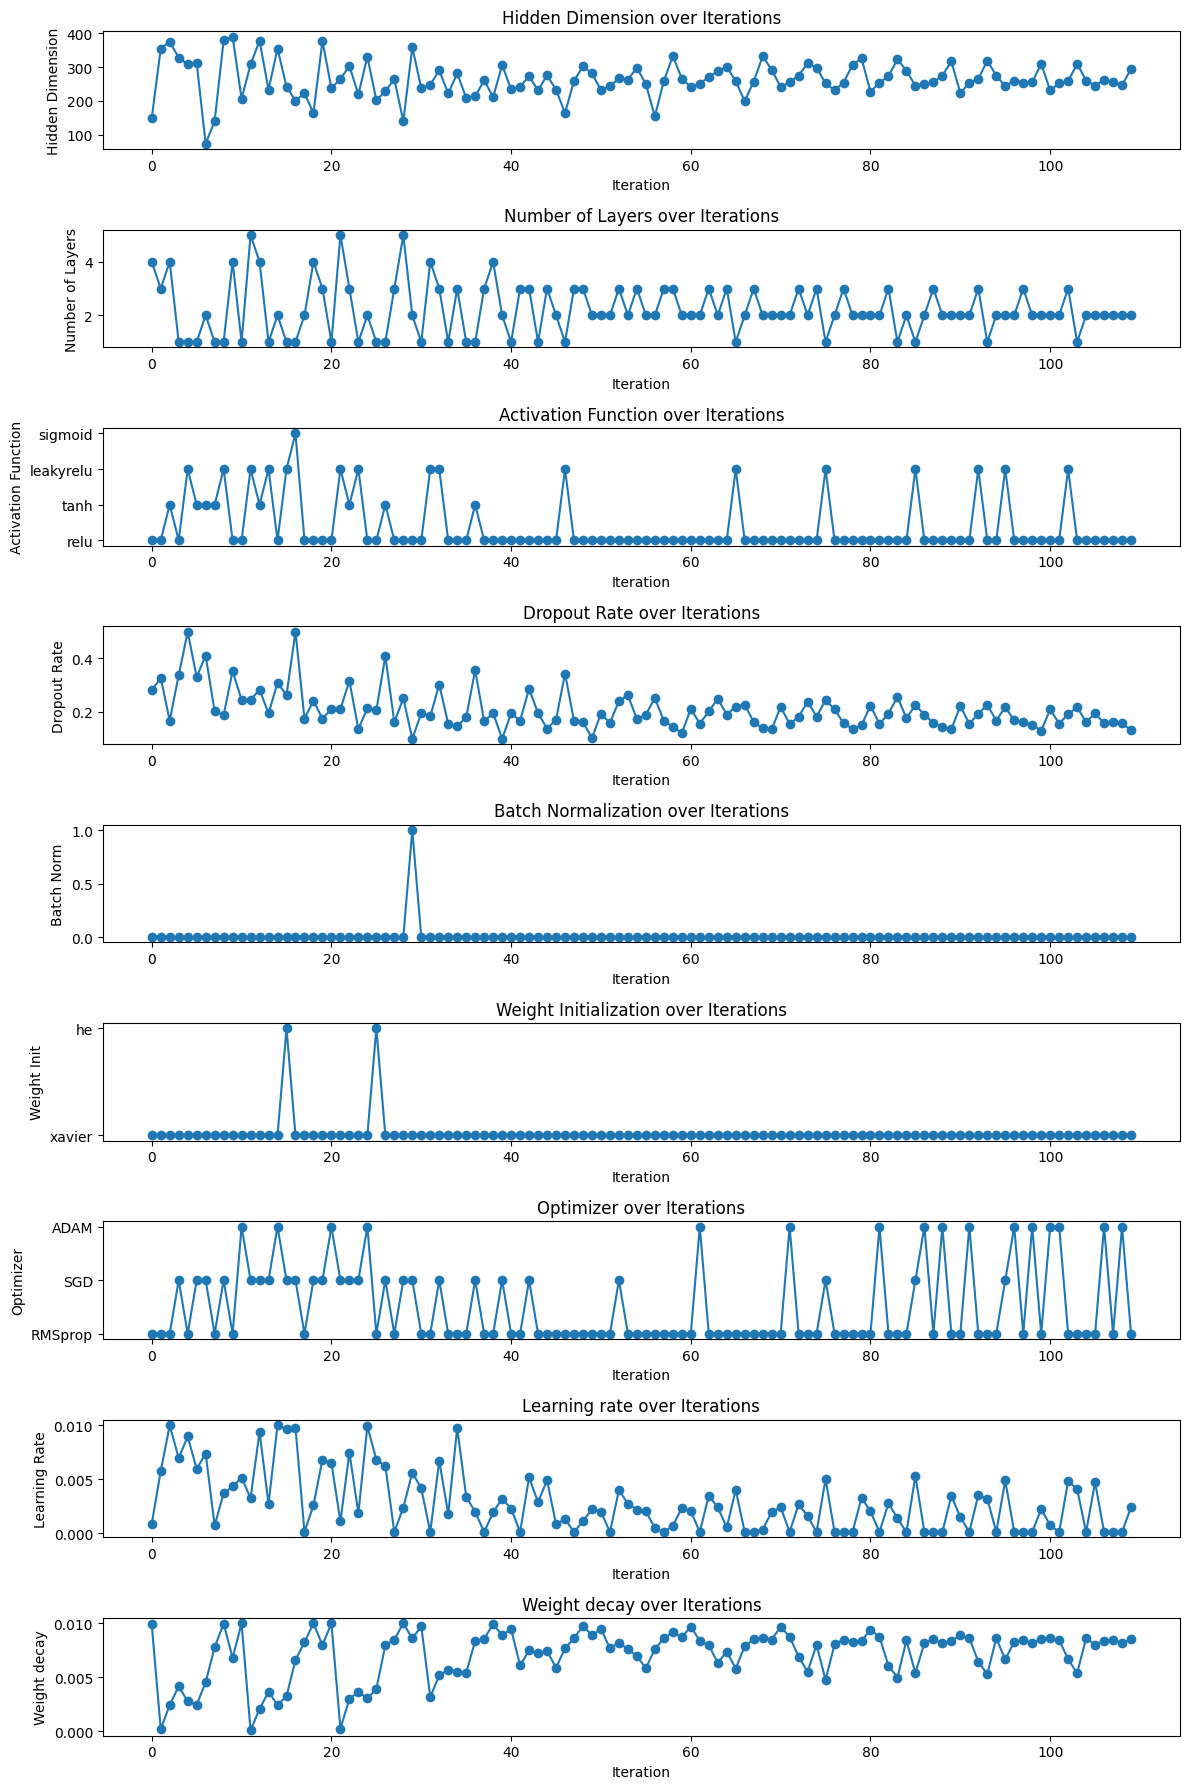

In [ ]:
hid_dims = [x[0] for x in param_log]
n_layers = [x[1] for x in param_log]
activation_function = [x[2] for x in param_log]
dropouts = [x[3] for x in param_log]
batch_norm = [x[4] for x in param_log]
w_init = [x[5] for x in param_log]
optimizer = [x[6] for x in param_log]
learning_rate = [x[7] for x in param_log]
weight_decay = [x[8] for x in param_log]


fig, axs = plt.subplots(9, 1, figsize=(12, 18))

axs[0].plot(hid_dims, marker='o')
axs[0].set_title('Hidden Dimension over Iterations')
axs[0].set_xlabel('Iteration')
axs[0].set_ylabel('Hidden Dimension')

axs[1].plot(n_layers, marker='o')
axs[1].set_title('Number of Layers over Iterations')
axs[1].set_xlabel('Iteration')
axs[1].set_ylabel('Number of Layers')

axs[2].plot(activation_function, marker='o')
axs[2].set_title('Activation Function over Iterations')
axs[2].set_xlabel('Iteration')
axs[2].set_ylabel('Activation Function')

axs[3].plot(dropouts, marker='o')
axs[3].set_title('Dropout Rate over Iterations')
axs[3].set_xlabel('Iteration')
axs[3].set_ylabel('Dropout Rate')

axs[4].plot(batch_norm, marker='o')
axs[4].set_title('Batch Normalization over Iterations')
axs[4].set_xlabel('Iteration')
axs[4].set_ylabel('Batch Norm')

axs[5].plot(w_init, marker='o')
axs[5].set_title('Weight Initialization over Iterations')
axs[5].set_xlabel('Iteration')
axs[5].set_ylabel('Weight Init')

axs[6].plot(optimizer, marker='o')
axs[6].set_title('Optimizer over Iterations')
axs[6].set_xlabel('Iteration')
axs[6].set_ylabel('Optimizer')

axs[7].plot(learning_rate, marker='o')
axs[7].set_title('Learning rate over Iterations')
axs[7].set_xlabel('Iteration')
axs[7].set_ylabel('Learning Rate')

axs[8].plot(weight_decay, marker='o')
axs[8].set_title('Weight decay over Iterations')
axs[8].set_xlabel('Iteration')
axs[8].set_ylabel('Weight decay')

plt.tight_layout()
plt.show()


In [58]:
optim_dict = {0: 'SGD', 1: 'RMSprop', 2: 'ADAM'}
act_dict = {0: 'relu', 1: 'leakyrelu', 2: 'tanh', 3: 'sigmoid'}
w_initial_dict = {0: 'xavier', 1: 'he'}

print(f"- Optimal hyperparameter settings -\n\n hid_dim: {int(best_params[0])}, n_layer: {int(best_params[1])}, activation: {act_dict[int(best_params[2])]}, dropout: {best_params[3]}, \n use_bn: {int(best_params[4])}, w_initial: {w_initial_dict[int(best_params[5])]}, optimizer: {optim_dict[int(best_params[6])]}, learning_rate: {best_params[7]}, weight_decay: {best_params[8]}")

- Optimal hyperparameter settings -

 hid_dim: 251, n_layer: 2, activation: relu, dropout: 0.156519618005224, 
 use_bn: 0, w_initial: xavier, optimizer: ADAM, learning_rate: 0.0001, weight_decay: 0.008395028190088367


In [70]:
df = load_exp_result('v2')

optim_result = df[df['hid_dim'] == 251]
optim_result

,train_losses,val_losses,train_accs,val_accs,train_acc,val_acc,test_acc,exp_name,val_loss,hid_dim,n_layer,activation,dropout,use_bn,w_initial,optimizer,learning_rate,weight_decay
1,"[1.8983453352739856, 1.6722351859329612, 1.598...","[1.7100252270698548, 1.6189957141876221, 1.573...","[33.7875, 41.4425, 44.085, 45.8075, 46.855, 48...","[40.83, 43.54, 45.71, 46.55, 47.72, 48.29, 49....",56.77,52.85,52.73,v2,1.353787,251,2,relu,0.15652,0,xavier,ADAM,0.0001,0.008395


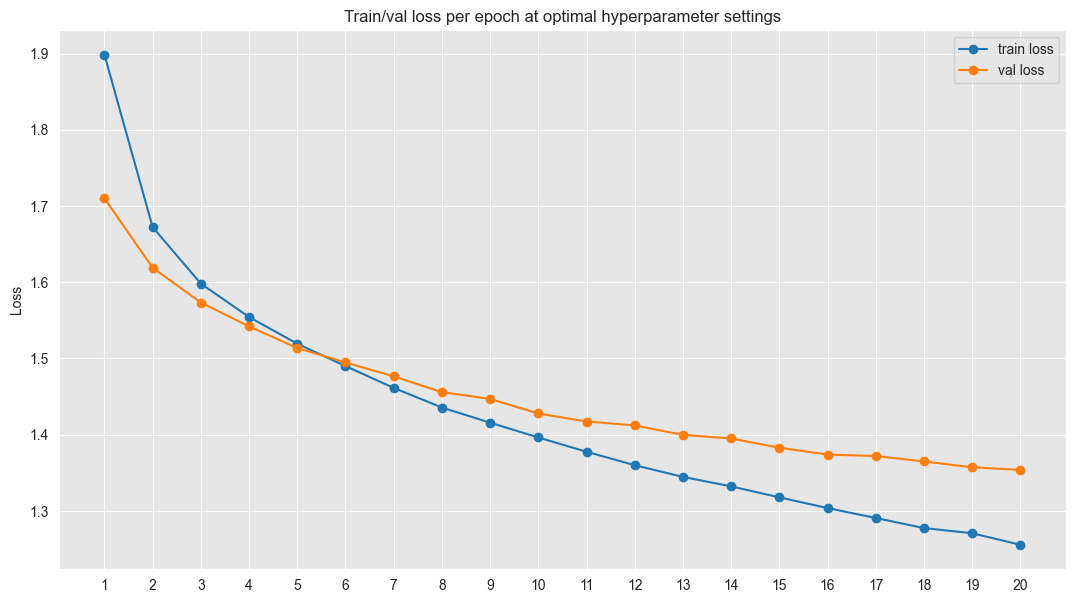

In [118]:
plt.figure(figsize=(13,7))
plt.plot(np.arange(1,len(optim_result['train_losses'].item())+1), optim_result['train_losses'].item(),marker= 'o', label='train loss')
plt.plot(np.arange(1,len(optim_result['val_losses'].item())+1), optim_result['val_losses'].item(),marker= 'o', label='val loss')
plt.xticks(np.arange(1,len(optim_result['train_losses'].item())+1), np.arange(1,len(optim_result['train_losses'].item())+1))
plt.legend()
plt.title('Train/val loss per epoch at optimal hyperparameter settings')
plt.ylabel('Loss')
plt.grid(True)
plt.show()

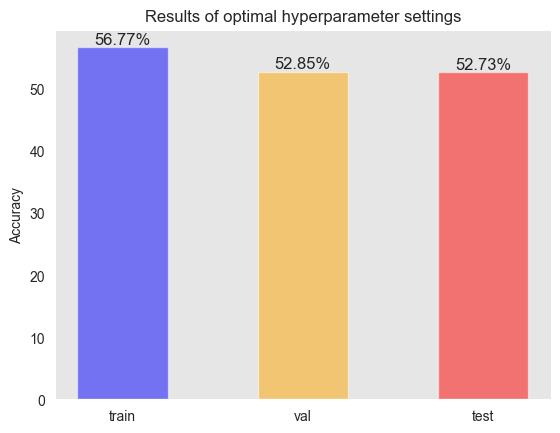

In [86]:
bar = plt.bar(['train','val','test'],[optim_result['train_acc'].item(),optim_result['val_acc'].item(),optim_result['test_acc'].item()], color = ['blue','orange','red'],alpha=0.5,width=0.5)

for rect in bar:
    height = rect.get_height()
    plt.text(rect.get_x()+rect.get_width()/2.0,height,  str(height) + '%', ha = 'center',va='bottom',size=12)

plt.title('Results of optimal hyperparameter settings')
plt.ylabel('Accuracy')
plt.grid(False)
plt.show()

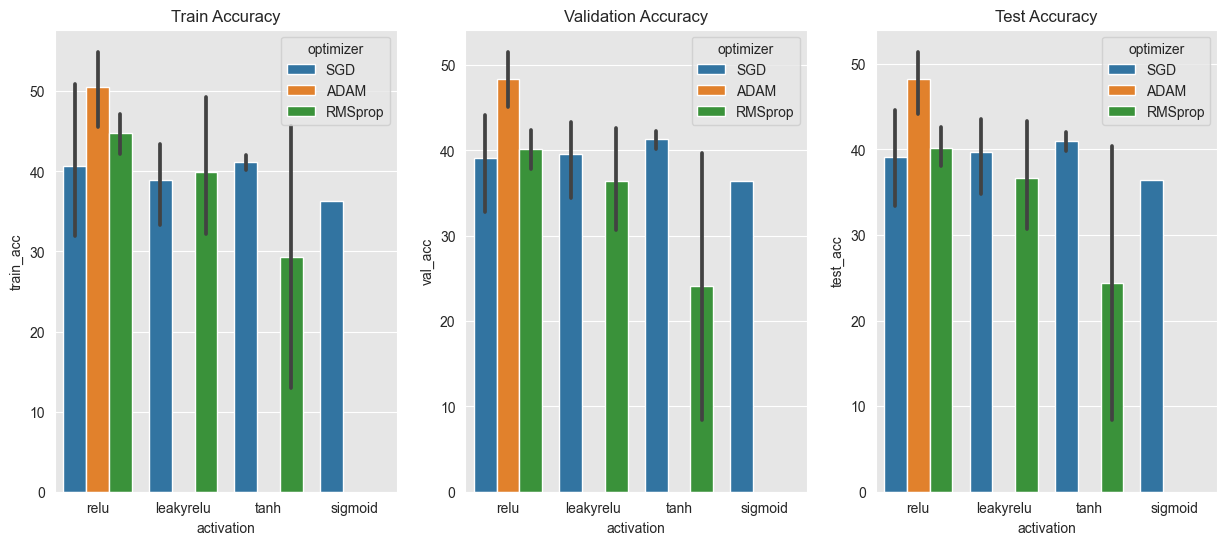

In [87]:
var1 = 'activation'
var2 = 'optimizer'
plot_acc(var1, var2, df)